# NLP (Natural Language Processing)

Via the site 'Beingdatum.com' I've followed the course: 'Guide on Deep Learning for NLP'.

This Notebook is to show you how Topic Modeling works.

## Topic Modelling

Most of the times, while analyzing text, we are required to identify the text, messages, paragraphs, articles, by its type. By type, what we mean whether that text is related to Politics, Sports, Business etc. When the volume of text data becomes huge, we need to ensure that we bucket different articles based on their semantic similarity, so that it’s easier to analyze. If a group of documents/data are semantically similar, then they tend to convey the same meaning or sense. Due to the large volume of text data we have, these days we need an automated way by which we can club similar documents together so that it is easy for us to analyze individual buckets at a time.

A classical example of this is a newspaper, where we have news feed from different sources classified based on their types.

In Python, we can accomplish this task by using libraries such as gensim and scikit. From here on we will call all instances of text corpus as documents. The basic assumption for grouping the documents is that each one of them is made up of topics. There can be several topics(sports, fashion, entertainment etc) within a document but there is invariably a single Topic that decides the central theme/type of a document. Topics can be similar to each other or can be completely different from each other. For instance, entertainment and fashion are similar in nature while Politics and Business are different from each other.

The following section will be a step by step guide of how we can analyse and bucket text corpus into semantically similar groups or topics.

## 1. Latent Semantic Analysis
LSA (Latent Semantic Analysis) also known as LSI (Latent Semantic Index) LSA uses bag of words(BoW) model, which results in a term-document matrix (occurrence of terms in a document). Rows represent terms and columns represent documents. LSA learns latent topics by performing a matrix decomposition on the document-term matrix using Singular value decomposition. LSA is typically used as a dimension reduction or noise reducing technique.

In [1]:
#Implementing LSA using Gensim

#import modules
import os.path
from gensim import corpora
from gensim.models import LsiModel
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.pyplot as plt

### Loading Data

You can find the data [here](https://s3.amazonaws.com/assets.datacamp.com/blog_assets/Latent+Semantic+Analysis+in+Python/articles+4.txt)

Please save this text in a notepad file as 'articles.txt' before proceeding

In [2]:
def load_data(path,file_name):
    """
    Input  : path and file_name
    Purpose: loading text file
    Output : list of paragraphs/documents and
             title(initial 100 words considered as title of document)
    """
    documents_list = []
    titles=[]
    with open( os.path.join(path, file_name) ,"r") as fin:
        for line in fin.readlines():
            text = line.strip()
            documents_list.append(text)
    print("Total Number of Documents:",len(documents_list))
    titles.append( text[0:min(len(text),100)] )
    return documents_list,titles

### Preprocessing Data

After data loading function, you need to preprocess the text. Following steps are taken to preprocess the text:

- Tokenize the text articles
- Remove stop words
- Perform stemming in text article

In [3]:
def preprocess_data(doc_set):
    """
    Input  : document list
    Purpose: preprocess text (tokenize, removing stopwords, and stemming)
    Output : preprocessed text
   """
    # initialize regex tokenizer
    tokenizer = RegexpTokenizer(r'\w+')
    # create English stop words list
    en_stop = set(stopwords.words('english'))
    # Create p_stemmer of class PorterStemmer
    p_stemmer = PorterStemmer()
    # list for tokenized documents in loop
    texts = []
    # loop through document list
    for i in doc_set:
        # clean and tokenize document string
        raw = i.lower()
        tokens = tokenizer.tokenize(raw)
        # remove stop words from tokens
        stopped_tokens = [i for i in tokens if not i in en_stop]
        # stem tokens
        stemmed_tokens = [p_stemmer.stem(i) for i in stopped_tokens]
        # add tokens to list
        texts.append(stemmed_tokens)
    return texts

### Prepare Corpus
Next step is to prepare corpus. Here, you need to create a document-term matrix and dictionary of terms.

In [4]:
def prepare_corpus(doc_clean):
    """
    Input  : clean document
    Purpose: create term dictionary of our corpus and Converting list of documents (corpus) into Document Term Matrix
    Output : term dictionary and Document Term Matrix
    """
    # Creating the term dictionary of our corpus, where every unique term is assigned an index. dictionary = corpora.Dictionary(doc_clean)
    dictionary = corpora.Dictionary(doc_clean)
    # Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
    doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]
    # generate LDA model
    return dictionary,doc_term_matrix

### Create an LSA model using Gensim

After corpus creation, you can generate a model using LSA.

In [5]:
def create_gensim_lsa_model(doc_clean,number_of_topics,words):
    """
    Input  : clean document, number of topics and number of words associated with each topic
    Purpose: create LSA model using gensim
    Output : return LSA model
    """
    dictionary,doc_term_matrix=prepare_corpus(doc_clean)
    # generate LSA model
    lsamodel = LsiModel(doc_term_matrix, num_topics=number_of_topics, id2word = dictionary)  # train model
    print(lsamodel.print_topics(num_topics=number_of_topics, num_words=words))
    return lsamodel

### Determine the number of topics

Another extra step needs to be taken to optimize results by identifying an optimum amount of topics. Here, you will generate coherence scores to determine an optimum number of topics.

In [6]:
def compute_coherence_values(dictionary, doc_term_matrix, doc_clean, stop, start=2, step=3):
    """
    Input   : dictionary : Gensim dictionary
              corpus : Gensim corpus
              texts : List of input texts
              stop : Max num of topics
    purpose : Compute c_v coherence for various number of topics
    Output  : model_list : List of LSA topic models
              coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, stop, step):
        # generate LSA model
        model = LsiModel(doc_term_matrix, num_topics=number_of_topics, id2word = dictionary)  # train model
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=doc_clean, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

In [7]:
#let's plot coherence score values

def plot_graph(doc_clean,start, stop, step):
    dictionary,doc_term_matrix=prepare_corpus(doc_clean)
    model_list, coherence_values = compute_coherence_values(dictionary, doc_term_matrix,doc_clean,
                                                            stop, start, step)
    # Show graph
    x = range(start, stop, step)
    plt.plot(x, coherence_values)
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence score")
    plt.legend(("coherence_values"), loc='best')
    plt.show()

In [8]:
#You can easily evaluate this graph. 
#Here, you have a number of topics on X-axis and coherence score on Y-axis. 
#Of the number of topics, 7 have the highest coherence score, so the optimum number of topics are 7.

### Run all the above functions

In [9]:
# LSA Model
number_of_topics=7
words=10
#document_list,titles=load_data("","articles.txt")
document_list = open("articles.txt", encoding="utf8")
clean_text=preprocess_data(document_list)
model=create_gensim_lsa_model(clean_text,number_of_topics,words)

[(0, '0.866*"â" + 0.155*"trump" + 0.126*"said" + 0.119*"say" + 0.073*"peopl" + 0.071*"one" + 0.071*"would" + 0.064*"year" + 0.059*"go" + 0.058*"new"'), (1, '0.419*"trump" + -0.192*"year" + 0.176*"â" + -0.157*"brexit" + -0.154*"eu" + -0.152*"hammond" + -0.136*"govern" + -0.135*"say" + -0.126*"statement" + -0.122*"uk"'), (2, '0.517*"trump" + -0.303*"â" + 0.205*"presid" + 0.202*"elect" + 0.185*"said" + 0.156*"vote" + -0.140*"min" + 0.137*"campaign" + 0.132*"trumpâ" + 0.118*"poll"'), (3, '-0.308*"poll" + -0.306*"vote" + 0.230*"say" + 0.188*"hammond" + -0.187*"remain" + 0.186*"statement" + -0.162*"leav" + -0.146*"min" + 0.142*"govern" + 0.138*"autumn"'), (4, '0.361*"min" + 0.258*"trump" + -0.201*"vote" + -0.172*"poll" + 0.167*"0" + -0.161*"â" + 0.155*"leagu" + 0.148*"goal" + 0.145*"1" + 0.129*"ball"'), (5, '0.306*"say" + -0.235*"bank" + -0.221*"said" + 0.206*"vote" + 0.190*"poll" + -0.167*"would" + 0.155*"min" + -0.148*"work" + -0.132*"health" + -0.130*"presid"'), (6, '0.462*"bank" + 0.271*

- Topic 1 : a, trump, say, said, would, peopl, clinton, one, campaign ((US Presidential Elections)
- Topic 2: citi, v, h, unit, west, manchest, apr, dec (English Premier League)
- Topic 3: eu, trump, say, a would, leav, uk, clinton, said, vote (US Presidential Elections,)
- Topic 4: trump, min, clinton, said, campaign, eu, vote, say, goal (US Presidential Elections, EPL)
- Topic 5: min, trump, clinton, goal, ball, 1, 0, win, leagu (US Presidential Elections, EPL)
- Topic 6: bank, eu, say, min, market, year, rate, leav, financi, cameron (Brexit and Market Condition)
- Topic 7: say, eu, said, vote, poll, campaign, govern, remain, leav, tax (US Presidential Elections and Financial Planning)

Here, 7 Topics were discovered using Latent Semantic Analysis. Some of them are overlapping topics. For Capturing multiple meanings with higher accuracy we need to try LDA (latent Dirichlet allocation). 

In [21]:
dictionary, doc_term_matrix = prepare_corpus(clean_text)
model_list, coherence_values = compute_coherence_values(dictionary, doc_term_matrix, clean_text, 7, 2, 3)

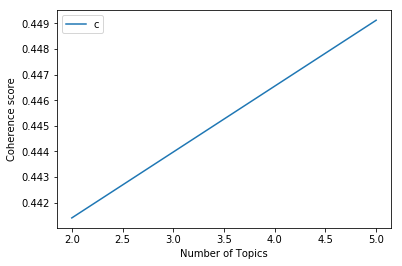

In [24]:
plot_graph(clean_text,2, 7, 3)

### Pros and Cons of LSA

LSA algorithm is the simplest method which is easy to understand and implement. It also offers better results compared to the vector space model. It is faster compared to other available algorithms because it involves document term matrix decomposition only.

Latent topic dimension depends upon the rank of the matrix so we can’t extend that limit. LSA decomposed matrix is a highly dense matrix, so it is difficult to index individual dimension. LSA unable to capture the multiple meanings of words. It is not easier to implement compared to LDA( latent Dirichlet allocation). It offers lower accuracy than LDA.

### Use Cases of Topic Modelling:
- Resume Summarization: It can help recruiters to evaluate resumes by a quick glance. They can reduce effort in filtering pile of resume.
- Search Engine Optimization: online articles, blogs, and documents can be tag easily by identifying the topics and associated keywords, which can improve optimize search results.
- Recommender System Optimization: recommender systems act as an information filter and advisor according to the user profile and previous history. It can help us to discover unvisited relevant content based on past visits.
- Improving Customer Support: Discovering relevant topics and associated keywords in customer complaints and feedback for examples product and service specifications, department, and branch details. Such information help company to directly rotated the complaint in respective department.
- In the healthcare industry, topic modeling can help us to extract useful and valuable information from unstructured medical reports. This information can be used for patients treatment and medical science research purpose.